# Imputing Fare

In [52]:
#load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
data = data.drop('Survived', axis=1)
data.head(n=6)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [2]:
from functon_scripts.find_nan_cols import find_nan_cols

find_nan_cols(data)
type(data.iloc[:, 0])

{'Age': 177, 'Cabin': 687, 'Embarked': 2}


pandas.core.series.Series

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from functon_scripts.CustomEstimators import DropColumns, EmbarkedImputer
from functon_scripts.SpecialImputers import DiscreteVar
from sklearn.preprocessing import OneHotEncoder

cols = data.columns.drop(['Embarked', 'Age', 'Sex', 'Fare'])
fare_bins = [-1, 5, 10, 35, 100, 250, np.inf]
age_bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
clean1 = ColumnTransformer([
    ('drp', DropColumns(drop_ix=[0, 2, 5, 6]), cols),
    ('ohe', OneHotEncoder(), ['Sex']),
    ('dAge', DiscreteVar(bins=age_bins), ['Age']),
    ('dFare', DiscreteVar(bins=fare_bins), ['Fare']),
    ('EmbImp', EmbarkedImputer(), ['Embarked'])
])
# clean1 --

clean_data = pd.DataFrame(clean1.fit_transform(data))

### Load clean data and fit model

In [54]:
Pclass_ix = np.s_[:, 0]
SibSp_ix = np.s_[:, 1]
Parch_ix = np.s_[:, 2]
Sex_ix = np.s_[:, 3:5]
Age_ix = np.s_[:, 5]
Fare_ix = np.s_[:, 6]
Embarked_ix = np.s_[:, 7:10]

y = clean_data.iloc[Fare_ix].astype(int)
X = np.c_[clean_data.iloc[Pclass_ix], clean_data.iloc[Sex_ix],
            clean_data.iloc[Embarked_ix], clean_data.iloc[SibSp_ix] + clean_data.iloc[Parch_ix]]

In [55]:
from sklearn.utils.multiclass import type_of_target

type_of_target(y)

'multiclass'

In [50]:
#train model
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

param_grid = [
    {'n_estimators': np.arange(95, 110, step=2),
     'max_depth': [2, 3, 4, 5],
     'max_leaf_nodes': [3, 4, 5, 6, 7]
    },
]

xgb = XGBClassifier()

grids = GridSearchCV(xgb, param_grid, scoring="f1_macro", return_train_score=True, cv=5)
grids.fit(X, y)

joblib.dump(grids.best_estimator_, 'filename.pkl')
grids.best_params_

{'max_depth': 4, 'max_leaf_nodes': 3, 'n_estimators': 103}

0.6118338832680039


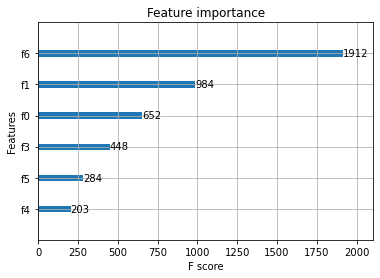

In [24]:
from xgboost import plot_importance

plot_importance(grids.best_estimator_)
print(grids.best_score_)

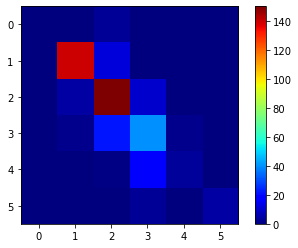

In [58]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

testdata = pd.read_csv(data_dir + 'test.csv')
testdata = testdata[~testdata.Fare.isnull()]
clean_data = clean1.fit_transform(testdata)

y = clean_data[Fare_ix].astype(int)
X = np.c_[clean_data[Pclass_ix], clean_data[Sex_ix],
            clean_data[Embarked_ix], clean_data[SibSp_ix] + clean_data[Parch_ix]]

y_hat = grids.best_estimator_.predict(X)

plt.imshow(confusion_matrix(y, y_hat), cmap=plt.get_cmap('jet'))
plt.colorbar()

### Note5:
obviously xgboost is not performing well. Let's try knn. But first of all I need to create Pipline to clean the data.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

param_grid = [
    {'n_neighbors': np.arange(5, 50, step=20)}
]

grids_knn = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="f1_macro", return_train_score=True, cv=5)
grids_knn.fit(X, y)

joblib.dump(grids_knn.best_estimator_, 'knn_best.pkl')
grids_knn.best_params_

{'n_neighbors': 5}

In [13]:
grids_knn.best_score_

0.4725408279579157

### Note8:
Okay knn performs poorly with respect to xgb, lets see by using logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression

param_grid = [
    {'C': np.arange(0.5, 1, step=0.1)}
]

grids_lgst = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear'), param_grid, scoring="f1_macro", return_train_score=True, cv=5)
grids_lgst.fit(X, y)

joblib.dump(grids_lgst.best_estimator_, 'knn_best.pkl')
grids_lgst.best_params_

{'C': 0.7}

In [39]:
y[ix]

179    0
263    0
271    0
277    0
302    0
378    0
413    0
466    0
481    0
597    0
633    0
674    0
732    0
806    0
815    0
822    0
872    0
Name: 6, dtype: int32

In [41]:
grids.best_params_

{'max_depth': 4, 'max_leaf_nodes': 3, 'n_estimators': 110}